Authors: Dror & Mariia

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from collections import Counter
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
df = pd.read_csv('customer_segmentation.csv', encoding="ISO-8859-1") # from https://www.kaggle.com/carrie1/ecommerce-data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 1 First, let's see what data do we have

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df.duplicated().sum()

5268

## 2 EDA

### 2.1. 25% of entries are null-valued customers. 

So, let's select this subgroup, save it separately and later check it. Should it be removed from our main data? 

Since we are clustering orders, these orders with undefined customers will be assigned to the same customer if we do some fillna - this is bad. Probably, we have to work with that data separately

In [7]:
null_customers = df[df.CustomerID.isna()]
null_customers.to_csv('null_customers.csv')  # later we will return to this
null_customers.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom


Now, we will deal with data without NaNs:

In [8]:
# a few options
df1 = df.dropna(axis = 0, subset = ['CustomerID'])
df2 = df[~df.CustomerID.isna()] 
np.all(df1 == df2)

True

### 2.2. Duplicates

In [9]:
df1.duplicated().sum()

5225

In [10]:
df = df1.drop_duplicates()

In [11]:
df.info()  # maybe reset index?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      401604 non-null object
StockCode      401604 non-null object
Description    401604 non-null object
Quantity       401604 non-null int64
InvoiceDate    401604 non-null datetime64[ns]
UnitPrice      401604 non-null float64
CustomerID     401604 non-null float64
Country        401604 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [12]:
dfr = df.reset_index()

### 2.3. Transform 'InvoiceDate' into some number of separate features

In [13]:
df['year'] = pd.DatetimeIndex(df['InvoiceDate']).year
df['month'] = pd.DatetimeIndex(df['InvoiceDate']).month
df['dayofweek'] = pd.DatetimeIndex(df['InvoiceDate']).dayofweek
df['weekofyear'] = pd.DatetimeIndex(df['InvoiceDate']).weekofyear
df['hour'] = pd.DatetimeIndex(df['InvoiceDate']).hour
df['dayofyear'] = pd.DatetimeIndex(df['InvoiceDate']).dayofyear

# looks like we got all information from the InvoiceDate, but let's not drop anything yet
# df = df.drop('InvoiceDate', axis=1)

In [14]:
# let's see how many unique values for each column maybe do we have
for col in df.columns:
    print(f'Column {col} has {len(np.unique(df[col]))} unique values')

Column InvoiceNo has 22190 unique values
Column StockCode has 3684 unique values
Column Description has 3896 unique values
Column Quantity has 436 unique values
Column InvoiceDate has 20460 unique values
Column UnitPrice has 620 unique values
Column CustomerID has 4372 unique values
Column Country has 37 unique values
Column year has 2 unique values
Column month has 12 unique values
Column dayofweek has 6 unique values
Column weekofyear has 51 unique values
Column hour has 15 unique values
Column dayofyear has 298 unique values


Regarding 6 days in a week :) probably, the orders are just not processed on some day of the week and hence moved to the next day. we will see further what happened maybe

In [15]:
df.dayofweek.value_counts()  # hmmm, doesn't support the hypothesis

3    81575
2    69753
1    67376
0    65715
6    61673
4    55512
Name: dayofweek, dtype: int64

### 2.4. Transform 'Country' column into: 1. binary column (UK or not),   2. onehotencoded

In [16]:
df['is_UK'] = df.Country.apply(lambda x: int(x == 'United Kingdom'))
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,dayofweek,weekofyear,hour,dayofyear,is_UK
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,2,48,8,335,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,2,48,8,335,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,2,48,8,335,1


one hot encode countries

In [17]:
df_Countries = pd.get_dummies(df.Country)
df_Countries.head()

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
df = pd.concat([df, df_Countries], axis=1)
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,...,0,0,0,0,0,0,0,0,1,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,...,0,0,0,0,0,0,0,0,1,0


### 2.5. Further steps

Later we will drop the column 'Country'. For now, we have to figure out what can we do with 'Description' and 'CustomerID'



As for Description, there are few options:


    - each value in this column should be turned into fixed length sequence of n-dimensional vectors, 
    where n - is either embedding dimension or size of vocabulary of most frequent words (this is CountVectorizer)

    - classify values in description column by item type or sth else (like stuff for kitchen/furniture/etc, idk)



As for CustomerID, 

    - I don't like that the values are integers, since there is no relations between these numbers, 
    in fact it's categorical feature, not numerical



### 2.6. Exploring 'Description' column

#### 2.6.1 vocabulary

In [19]:
# from collections import Counter

vocabulary = Counter({ word.lower(): 0 for descript in df.Description for word in descript.split() })
for descript in df.Description:
    words = [w.lower() for w in descript.split()]
    for word in words:
        if word in vocabulary:
            vocabulary[word] += 1

vocabulary.most_common(10)

[('set', 41053),
 ('of', 40858),
 ('bag', 38090),
 ('red', 32254),
 ('heart', 29047),
 ('retrospot', 26754),
 ('vintage', 25761),
 ('design', 23663),
 ('pink', 20264),
 ('christmas', 19082)]

In [20]:
i = 200
print(f'The size of vocabulary: {len(vocabulary)}')
print(f'The least common word out of top frequent {i} is \
\'{vocabulary.most_common(i)[-1][0]}\' occuring {vocabulary.most_common(i)[-1][1]} times')

The size of vocabulary: 2242
The least common word out of top frequent 200 is 'picnic' occuring 1932 times


In [21]:
top200 = [w[0] for w in vocabulary.most_common(200)]

a bit of fun with wordcloud

In [22]:
all_words = [word.lower() for descr in df.Description for word in descr.split()]
words_from_top_200 = [w for w in all_words if w in top200]  # can also use this for wordcloud, the plot will be different

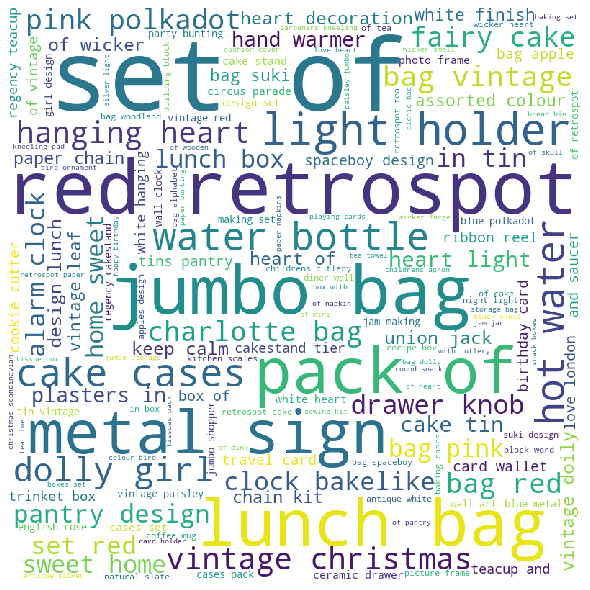

In [23]:
from wordcloud import WordCloud, STOPWORDS

# locally
stopwords = set(STOPWORDS)    

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(' '.join(all_words)) 
                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

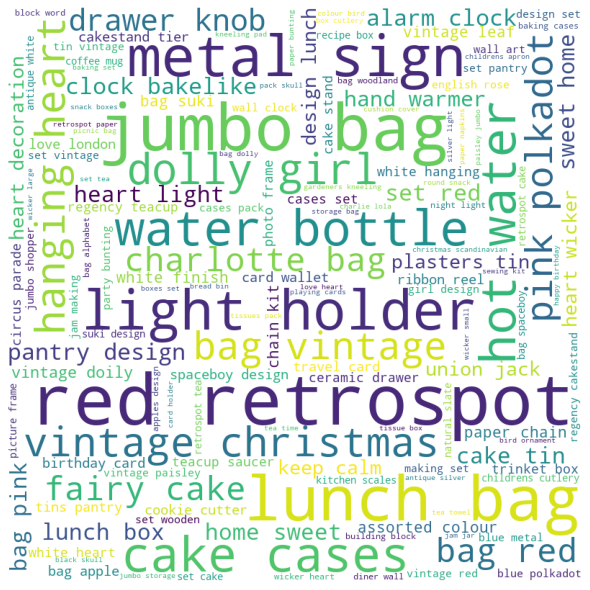

In [22]:
# in colab! 
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(' '.join(all_words)) 
                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#### 2.6.2 discription length & how many words are in top-200

In [24]:
descr_lengths = [len(descr.split()) for descr in df.Description]  # need to know the max length in order to decide how to pad

In [25]:
min(descr_lengths), max(descr_lengths)

(1, 8)

In [26]:
how_many_words_from_top_200 = []
if_more_than_a_half_in_top200 = 0

for descr in df.Description:
    hmwft200 = 0  # hmwft200 = how many words from top2000
    words = [w.lower() for w in descr.split()]
    for w in words:
        if w in top200:
            hmwft200 +=1
    how_many_words_from_top_200.append(hmwft200)
    if hmwft200 >= len(words) // 2:
        if_more_than_a_half_in_top200 += 1

min(how_many_words_from_top_200), max(how_many_words_from_top_200), if_more_than_a_half_in_top200/len(df)

(0, 8, 0.8969855877929502)

Okay, now we can really say that 200-dimensional vectors will be good. So, probably, we can turn Description column into 8 200-dimensional vectors. Then, we can reduce dimension from 1600 to k, turn it into sth dense and append this k new columns to df

Okay, possible plots:

    - plot boxplots for features with small number of unique values

    - for Country, week, dayofweek, dayofyear and month, etc we can aggregate total number of orders, total sum of orders made, etc

    - sth else?
